Load Data with Language Labels

In [14]:
# Cell 1: Load data with language labels
import pandas as pd
import numpy as np

src_path = '/kaggle/input/cse425-datasets'  # Adjust path as needed
df = pd.read_csv("/kaggle/input/cse425-datasets/combined_mfcc(GTZANBanglaBeats)_30sec.csv")

# Create language labels: GTZAN = English (0), BanglaBeats = Bangla (1)
language_labels = df['language'].apply(lambda x: 0 if x == 'eng' else 1).values
language_names = np.where(language_labels == 0, 'English', 'Bangla')

# Drop non-feature columns
df_features = df.drop(columns=['filename', 'label', 'length', 'language'])

print(f"Dataset shape: {df_features.shape}")
print(f"English samples: {(language_labels == 0).sum()}")
print(f"Bangla samples: {(language_labels == 1).sum()}")
df_features.head()

Dataset shape: (2617, 57)
English samples: 1000
Bangla samples: 1617


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


Standardize Features

In [15]:
# Cell 2: Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)
print(f"Scaled data shape: {X_scaled.shape}")

Scaled data shape: (2617, 57)


PCA + K-Means Baseline (for Language Clustering)

In [16]:
# Cell 3: PCA + K-Means Baseline (cleaned)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_clustering(X, labels_pred, method_name):
    return {
        'Method': method_name,
        'Silhouette Score': silhouette_score(X, labels_pred),
        'Calinski-Harabasz Index': calinski_harabasz_score(X, labels_pred),
    }

# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means with k=2 (English vs Bangla)
kmeans_pca = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

# Evaluate
pca_results = evaluate_clustering(X_pca, labels_pca, 'PCA + K-Means')
print("=== PCA + K-Means Baseline ===")
for key, value in pca_results.items():
    if key != 'Method':
        print(f"{key}: {value:.4f}")

=== PCA + K-Means Baseline ===
Silhouette Score: 0.3666
Calinski-Harabasz Index: 1696.3622


Implement VAE for Language Feature Extraction

In [17]:
# Cell 4: VAE Implementation
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics

# VAE hyperparameters
input_dim = X_scaled.shape[1]  # 57 features
latent_dim = 2  # 2D latent space for visualization

# Encoder
inputs = layers.Input(shape=(input_dim,), name='encoder_input')
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(16, activation='relu')(latent_inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      1,856 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │        528 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,452 (9.58 KB)

 Trainable params: 2,452 (9.58 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,473 (9.66 KB)

 Trainable params: 2,473 (9.66 KB)

 Non-trainable params: 0 (0.00 B)

Custom VAE Class with Training Loop

In [18]:
# Cell 5: Custom VAE Class
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss (MSE)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=1)
            )
            
            # KL Divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            
            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# Instantiate and train VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

history = vae.fit(X_scaled, epochs=120, batch_size=32, verbose=1)

Epoch 1/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - kl_loss: 0.3121 - loss: 60.2928 - reconstruction_loss: 59.9807
Epoch 2/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.4061 - loss: 54.4073 - reconstruction_loss: 54.0012
Epoch 3/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 2.6426 - loss: 47.9253 - reconstruction_loss: 45.2828
Epoch 4/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.4097 - loss: 42.6955 - reconstruction_loss: 39.2859
Epoch 5/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.5122 - loss: 39.7050 - reconstruction_loss: 36.1928
Epoch 6/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.5545 - loss: 37.7301 - reconstruction_loss: 34.1756
Epoch 7/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.4932 - loss: 36.6048 - reconstruction_loss: 33.1116
Epoch 8/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.4616 - loss: 37.5457 - reconstruction_loss: 34.0841
Epoch 9/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.4815 - 

Cluster VAE Latent Features & Compare

In [19]:
# Cell 6: VAE Clustering and Evaluation (cleaned)
# Extract latent representations
z_mean_latent, _, _ = encoder.predict(X_scaled)

# K-Means on VAE latent space (k=2 for language clustering)
kmeans_vae = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_vae = kmeans_vae.fit_predict(z_mean_latent)

# Evaluate VAE clustering
vae_results = evaluate_clustering(z_mean_latent, labels_vae, 'VAE + K-Means')
print("\n=== VAE + K-Means ===")
for key, value in vae_results.items():
    if key != 'Method':
        print(f"{key}: {value:.4f}")

# Simple comparison printout
print("\n=== Comparison: PCA vs VAE (Silhouette, Calinski-Harabasz) ===")
print(f"PCA  - Silhouette: {pca_results['Silhouette Score']:.4f}, CH: {pca_results['Calinski-Harabasz Index']:.2f}")
print(f"VAE  - Silhouette: {vae_results['Silhouette Score']:.4f}, CH: {vae_results['Calinski-Harabasz Index']:.2f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

=== VAE + K-Means ===
Silhouette Score: 0.3351
Calinski-Harabasz Index: 1393.1333

=== Comparison: PCA vs VAE (Silhouette, Calinski-Harabasz) ===
PCA  - Silhouette: 0.3666, CH: 1696.36
VAE  - Silhouette: 0.3351, CH: 1393.13


Visualize Clusters with t-SNE

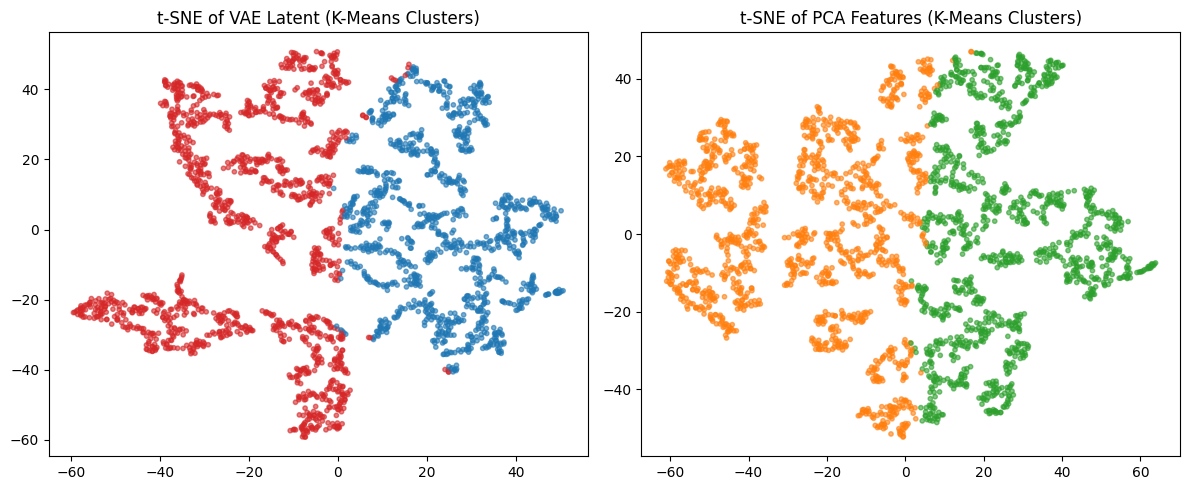

In [20]:
# Cell 7: Visualization (Easy Task: model vs baseline clusters)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Remove true label colors and use predicted cluster colors
pred_colors_vae = ['tab:blue' if c == 0 else 'tab:red' for c in labels_vae]
pred_colors_pca = ['tab:green' if c == 0 else 'tab:orange' for c in labels_pca]

# t-SNE on VAE latent space
tsne_vae = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_vae = tsne_vae.fit_transform(z_mean_latent)

# t-SNE on PCA features (baseline)
tsne_pca = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_pca = tsne_pca.fit_transform(X_pca)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_tsne_vae[:, 0], X_tsne_vae[:, 1], c=pred_colors_vae, alpha=0.6, s=10)
axes[0].set_title('t-SNE of VAE Latent (K-Means Clusters)')

axes[1].scatter(X_tsne_pca[:, 0], X_tsne_pca[:, 1], c=pred_colors_pca, alpha=0.6, s=10)
axes[1].set_title('t-SNE of PCA Features (K-Means Clusters)')

plt.tight_layout()
plt.savefig('clustering_visualization.png', dpi=150)
plt.show()